---
title: "Writing Stable Diffusion from Scratch 11"
reading-time: 
date: "2023-4-4"
categories: [fastaipart2,Stable-Diffusion]
---

All credits goes to fast.ai All mistakes are mine. <br>
You should know and practice following after this blog post :<br> 1- Making a flexible learner <br>
2- Start to build our framework 


In [1]:
!pip install -Uqq git+https://github.com/fastai/course22p2


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 11.0 MB/s eta 0:0

This is where we take a halt and we say, okay, let's build up a framework that we can use to rapidly try things and understand when things are working and when things aren't working. So we're going to start creating a learner. So what is learner? It's basically the idea is this learner is going to be something that we build which will allow us to try like anything that we can imagine very quickly and we will build that on top of that learner, things that will allow us to introspect what's going on inside a model will allow us to do multi process CUDA to go fast. It will allow us to add things like data augmentation. It will allow us to try a wide variety of architectures quickly and so forth. So that's going to be the idea and of course we're going to create it from scratch. 

And so let's start with fashion MNIST before and let's create a dataloader class, which is going to look a bit like what we had before, where we're just going to pass in. This is just couldn't be simpler, right? We're just going to pass in two dataloaders and store them away and I'm going to create a class method from dataset dictionary. And what that's going to do is it's going to call dataloader on each of the dataset dictionary items with our batch side batch size and instantiate our class. So if you haven't seen classmethod before, it's what allows us to say dataloaders dot something. In order to construct this, we're going to put this in in it just as well, but we'll be building more complex data loaded things later. So I thought we might start by kind of getting the basic structure right. So this is all pretty much the same as what we've had before, not doing anything on the device here because that's we know that didn't really work. Okay. Oh, this is an old thing. You don't need to cuda anymore. So we're going to use to_device. So here's a, here's an example of a very simple learner that fits on one screen, and this is basically going to replace our fit function. So a learner is going to be something that is going to train or learn a particular model using a particular set of data load as a particular loss function. But some particular learning rate and some particular optimizer or some particular optimization function. Now normally, you know, most people would often kind of store each of these away separately by writing like self.model equals model, blah, blah, blah. Right. And as I think we've talked about before, that's, you know, that kind of huge amounts of boilerplate. It just it's more stuff that you can get wrong and it's more stuff to mean that you have to read to understand the code and yeah, don't like that kind of repetition. So instead we just call fc.store_attr() to do that all in one line. Okay. So that basic idea with a class is to think what's the information it's going to need. So you pass that, all the constructor store away and then our fit function is going be got the basic stuff that we have for keeping track of accuracy. So this is only work for stuff that's a classification where we can use accuracy, put the model on our device, create the optimizer store, how many epochs we're going through. Then for each epoch we'll call the one epoch function and the one epoch function. We're going to either do train or evaluation. So we pass in true if we're training and false if we're evaluating. And they're basically almost the same.



In [2]:
#|export
import math,torch,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [3]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn,tensor
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
logging.disable(logging.WARNING)

## Learner

In [6]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [8]:
bs = 1024
tds = dsd.with_transform(transformi)

In [9]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

We basically set the model to training or not. We then decide whether to use the validation set or the training set based on whether we're training. And then we go through each batch in the dataloader and call one batch. And one batch is then the thing which is going to put our batch onto the device, call our model, call our loss function. And then if we're training, then do our backward step, our optimizer step in zero gradient, and then finally calculate our metrics or stats. And so here's where we calculate our metrics. So that's basically what we have there. So let's go back to using an MLP we call FIT. And the way it goes. This is an era here pointed out by Kevin thank you self.model.to that to one thing I guess we could try now is we think that maybe we can use more than one process so let's try that.
  again and let's check htop. Oh so fast. I didn't even see. Hey guys, you can see all 4 cpu's being used once. Bang, it's done. Okay, so that's pretty great. Let's see how fast it looks here. Bump, bump. All right. Lovely. Okay, so that's a good sign. 
  
We've got a learner that can fit things, but it's not very flexible. It's not going to help us, for example, with our auto encoder, because there's no way of like just, you know, changing which  things are used for predicting with or for coupling with. We can't use it for anything except things that involve accuracy with a binary classification. Sorry, a right, sorry. Yeah. A multiclass classification. It's not flexible at all, but it's a start. And so I wanted to basically this all on one screen so you can see what the basic learner looks like. All right, so how do we do things other than multiclass accuracy? 

I decided to create a metric class and basically a metric class. It's a something where we are going to define subclasses of it that calculate particular metrics. So for example, here I've got a subclass of a metric called accuracy. So if you haven't done subclasses before, you can basically think of this as saying, Please copy and paste all the code from here into here for me. But the bit that says def calc, replace it with this version. So in fact this would be identical to copying and pasting this whole thing, typing accuracy here and replacing the definition calc with that. That's what is happening here when we do subclasses. So it's basically and pasting all that code in there. For us, it's actually more powerful than that. There's more we can do with that. But in this case, this is all that's happening with this subclasses and that's this is called setting all these that that's 



In [10]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [11]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [12]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.17530390625 0.5987
0 False 1.1203112723214286 0.6135857142857143


## Basic Callbacks Learner

In [13]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [14]:
#|export
class Callback(): order = 0

In [15]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [16]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [17]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [18]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [19]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [20]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [21]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [22]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

## Metrics

so the accuracy metric is here and then this is kind of our really basic metric which is we're going to use for just for loss. And so what happens is we're going to let's, for example, create an accuracy metric object. We're basically to add in mini batches of data, right? So for example, here's a mini batches of inputs and predictions. Here's another mini batch of inputs and predictions, and then we're going to call dot value and it will calculate the accuracy. Now the value is a neat little thing. It doesn't require parentheses after it because it's called a property. And so a property is something that just calculates automatically without putting having to put parentheses. That's what a property is, what property getter anyway. And so they look like this, you give it a name. And so we are going to be each time we call ADD, we are going to be storing that input and that target and also the number of items in the mini batch. Optionally for now, that's just always going to be one. And you can see here that we then call dot Calc, which is going to call the accuracy_calc. So just see how they equal and then we're going to append to the list of values that calculation. And we're also going to append to the list of ends in this case, just one. And so then to calculate the value, we just do that. So that's all that's happening for accuracy. And then we can do for loss. We can just use metric directly because metric will just calculate the average of whatever it's passed. So we can say, oh, add the number 0.6, so the target's optional and saying this is a mini batch of size And then add the value 0.9 with a mini batch size of two and then get the value. And as you can see, that's exactly the same as the weighted average of 0.6 and point nine with weights of 32 and two. So created a metric class. And so that's something that we can use to create any metric we like just by overriding calc. Or we could create totally things from scratch as long as they have an add and a value. Okay, 

so we're now going to change our learner and what we're going to do is we're going to keep the same basic structure. So it's going to be fit. It's going to go through each epoch. It's going to call one epoch passing and true and false. As for training and validation, one epoch is going to go through each batch in the data oader and call one batch. One batch is going to the prediction get loss and if it's training, it's going to do that backward step and zero grade. But there's a few other things going on. So let's take a look. Well, actually, let's just look at it in use first. So when we use it, we're going to be creating a learner with the model dataloaders, last function learning rate and some callbacks, which we'll learn about in a moment and we call fit. 



In [23]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [24]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [25]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [26]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

## Some callbacks

```
pip install torcheval
```

In [27]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean

In [28]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [29]:
metric.reset()
metric.compute()

tensor(nan)

In [30]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [31]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [32]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [33]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.602', 'loss': '1.183', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.700', 'loss': '0.847', 'epoch': 0, 'train': 'eval'}


## Flexible learner

In [34]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [35]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

NB: I added `self.n_inp` after the lesson. This allows us to train models with more than one input or output.

And it's going to do our thing. And look, we're going to have charts and stuff. All right? So the basic idea is going to look very similar. So we're going to call fit. So when we construct it, we're going to be passing in exactly the same things as before. But we've got one extra thing callbacks, which we'll see in a moment, store the attributes as before, and we're going to be doing some stuff with the callbacks. So when we call Fit for this number of epochs, we're going to store away how many epochs we're going to do. We're also going to store away the actual range that we're going to loop through as soft epochs. So here's that looping through so epochs, we're going to create the optimizer using the optimizer function and the parameters, and then we're going to call _fit. Now, I want to know if is underscore fit, why didn't we just copy and paste so this into here Why why do this? It's because we've created a special decorator with callbacks. What does that do? 

So it's up here with callbacks. With callbacks is a class. It's going to just store one thing, which is the name. In this case, the name is fit. And what it's going to do is Now, this is a decorator, right? So when we call it remember, decorators get past a function. So it's going to get past whole function. And that's going to be called if that's a __call. Remember, is what happens when a class is treated, an object is treated as if it's a function. So it's going to get past this function. So this function is underscore fit. And so what we want to do is we want to return a different function. It's going to, cause, call the function that we were asked to call using the arguments and key documents we were asked to use. But before it calls that function, it's going to call a special method called callback passing in the string before in this case before underscore, fit. After it's completed, it's going to call that method called callback and passing the string after underscore fit, and it's going to wrap the whole thing in a try except. BLOCK And it's going to be looking for an exception called Cancel Fit Exception. And if it gets one, it's not going to complain. So let me explain what's going on with all of those things. 

Let's look at example of a callback. Let's change this DeviceCB So for example, here is a callback called DeviceCB Device callback and before FIT will be called automatically before that underscore fit method is called and it's going to put the model onto our device CUDA or MPS if we have one. Otherwise it would just be on GPU. So what's going to happen here? So it's going to call, we're going to call fit. It's going to go through these lines of code. It's going to call, underscore, a fit. Underscore fit is not this function underscore fit is this function with F is this function. So it's going to call our learn act callback passing in before underscore, fit and callback is defined here. What's callback going to do? It's going to be past the string before underscore it. It's going to then go through each of our callbacks sorted based on their order. And you can see here callback can have an order and it's going to look at that callback and try to get an attribute called before underscore fit and it will find one. And so then it's going to call that method. Now, if that method doesn't exist, it doesn't appear at all, then getattr will return this instead. Identity is a function just here. This is an identity function. All it does is whatever arguments it gets passed, it returns them. If it's not past any arguments, it just returns. So there's a lot of python going on here and that is why we did that. 

Foundations lesson. And so for people who haven't done a lot of this python, there's going to be a lot of stuff to experiment with and learn about. And so do ask on the forums if any of these bits get confusing. But the best way to learn about these things is to open up this Jupyter Notebook and try and create really simple versions of things. Right? So for example, let's try identity. Identity. How exactly does identity work? I can call it, and it gets nothing. I can call it with one spec one I could call it with. I get back, I got it with a yes, fully tested this, call it with a one and get a one. And how is it doing that exactly. So remember we can add a break point and this is be a great time to really test your debugging skills. Okay so remember in our debugger we can hit H to find out what the commands are, but you really should do a tutorial on the debugger if you're not familiar with it. And then we can step through each one. So I can now print args and it's actually a trick which I like is that args is actually a command funnily enough, which I'll just tell you the arguments to any function, regardless of what they're called, which is kind of nice. And so then we can step through by pressing and, and after this we can check like, okay, what is X now and what is args now, right? So remember it really experiment with these things. So anyway, we're going to talk about this a lot more in the next lesson. But before that, if you're not familiar with try except blocks, you know, spend some time practicing them. If you're not familiar with decorators, well, we've seen them before, So go back and look at them again really carefully. If you're not familiar with the debugger practice with that, if you haven't spent much time with get at, try remind yourself about that. So try to get yourself really familiar and comfortable as much as possible with the pieces, because if you're not comfortable with the pieces and the way put the pieces together is going to be confusing. There's actually something in education in kind of the theory of education called cognitive load theory. And The theory of cognitive basically cognitive load theory says if you're trying to learn something, but your cognitive load is really high because of all lots of other things going on at the same time, you're not going to learn it. So it's going to be hard for you to learn this framework that we're building. If you have too much cognitive load of like, what the hell's a decorator or what they getattr or what to sort of do or what's possible, you know, all these things. Now, I actually spent quite a bit of time trying to make this as simple as possible, but but also as flexible as it needs to be for the rest of the course. And this is this is this is as simple as I could get it. So these are kind of things that you actually have to learn. But in doing so, you're going to be able to write some really, you know, powerful and general code yourself. So hopefully you'll find this a really valuable and mind expanding exercise in in bringing high level software engineering skills to your data science work. Okay. So with that, this looks like a good place to leave it and look forward to seeing you next time. 


In [36]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [37]:
model = get_model()

accuracy,loss,epoch,train
0.596,1.167,0,train
0.729,0.794,0,eval


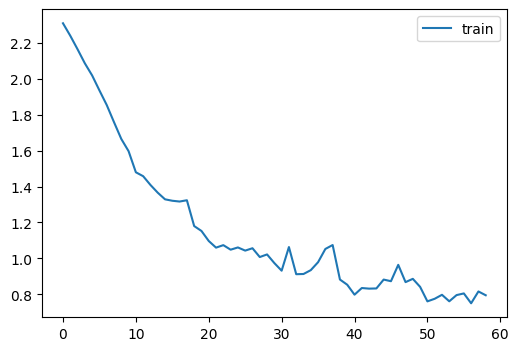

In [38]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [39]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [40]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.616,1.168,0,train
0.719,0.789,0,eval


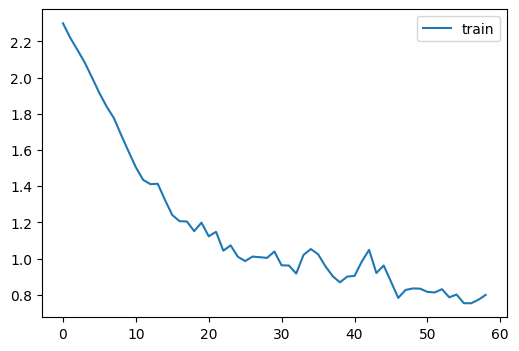

In [41]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [42]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [43]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.676,0.936,0,train
0.791,0.585,0,eval


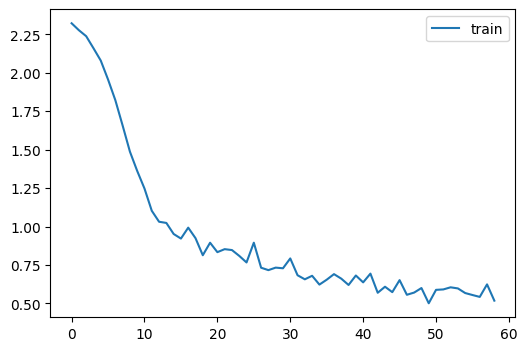

In [44]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [45]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

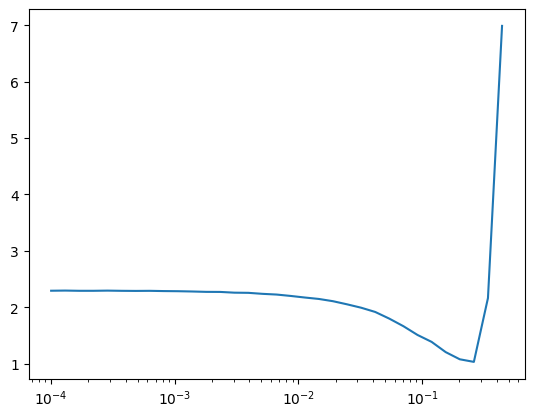

In [46]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [47]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [48]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

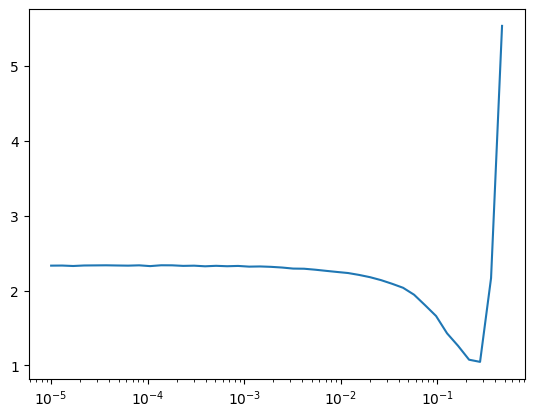

In [49]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [50]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

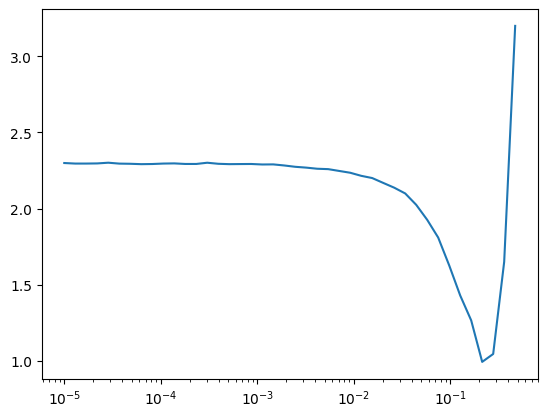

In [51]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()